In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/OptML/miniproject_OPTML')

In [3]:
from scipy.io import loadmat
from utils import *
from pathlib import Path

DATA_ROOT = Path('/content/drive/MyDrive/OptML/miniproject_OPTML')
data = loadmat(DATA_ROOT/'emnist-digits.mat')

In [4]:
import matplotlib.pyplot as plt
import numpy as np


In [5]:
dataset = data['dataset'][0, 0]
train = dataset[0][0, 0]
test = dataset[1][0, 0]
mapping = dataset[2]

train_images = train['images']   # Shape: (N, 28*28)
train_labels = train['labels']  # Shape: (N, 1)
train_writers = train['writers']

In [6]:
X = train_images.astype(np.float32) / 255.0  # Normalize to [0, 1]
y = train_labels.flatten().astype(np.int64)

# Wrap into a datalist with a single client
datalist = [(X, y)]

test_images = test['images'].astype(np.float32) / 255.0
test_labels = test['labels'].flatten().astype(np.int64)


In [7]:
from features_utils import *

[0]


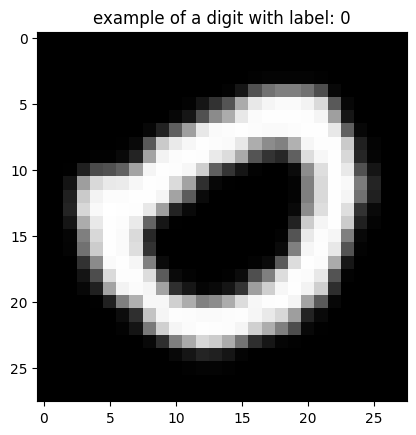

In [8]:
i = 115
img = train_images[i].reshape(28, 28)
print(train_labels[i])
plt.imshow(img, cmap='gray')
plt.title("example of a digit with " +f"label: {train_labels[i][0]}")
plt.show()


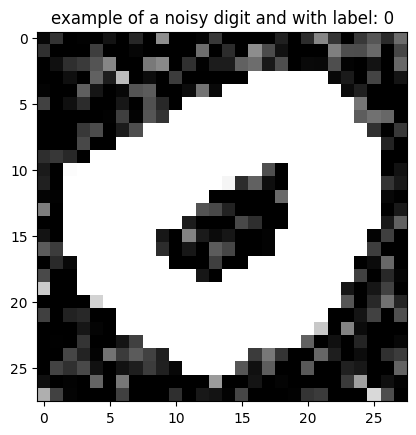

In [37]:
noise_std = 0.25
noised_number = noise_adder(train_images[i],noise_std).reshape(28,28)
plt.imshow(noised_number, cmap='gray')
plt.title("example of a noisy digit and with " +f"label: {train_labels[i][0]}")
plt.show()


In [10]:
n_clients = 30
datalist = make_femnist_datasets(X,y,train,n_clients)
# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print(f"case with {n_clients} clients, with feature distribution shift")
model = fedavg(datalist, T, K, gamma)


case with 30 clients, with feature distribution shift
round :  1
round :  2
round :  3
round :  4
round :  5


In [11]:
# Evaluate
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

Test Accuracy with 30 ): 81.15%


In [12]:
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

# 1) Create MADE data loaders
made_loaders = [
    DataLoader(
        TensorDataset(
            torch.tensor(X, dtype=torch.float32),
            torch.zeros(len(X), dtype=torch.float32)
        ),
        batch_size=64,
        shuffle=True
    )
    for X, _ in datalist
]

# 2) Train global MADE
global_made = train_global_made(
    made_loaders,
    dim=28*28,
    hid=100,
    rounds=T,
    local_epochs=1
)

# 3) Compute sample-weights alpha for each client
sample_weights = []
for ld in made_loaders:
    local_made = MADE(28*28, 100)
    local_state = train_local_made(local_made, ld, epochs=1)
    local_made.load_state_dict(local_state)

    alpha = compute_sample_weights(global_made, local_made, ld,device = 'cpu')
    # alpha is a FloatTensor of shape [n_samples] for this client
    sample_weights.append(alpha)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Instead of oversampling, just record:
#      - alphas_list (one alpha-tensor per client)
#      - client_sizes (one integer per client)
#    and leave datalist as-is.

alphas_list = sample_weights                  # list of length n_clients, each alpha has shape (N_k,)
client_sizes = [ len(y) for (_, y) in datalist ]  # e.g. [N_1, N_2, ..., N_K]

# 5) Call the fedavg_disk directly on (X,y), alphas_list, and client_sizes
print(f"case with {len(datalist)} clients, with feature distribution shift")
model,loss = fedavg_disk(
    datalist,       # unchanged: [(X1, y1), (X2, y2), …]
    alphas_list,    # per-sample weights from Phase 1
    client_sizes,   # [len(y1), len(y2), …]
    T, K, gamma
)

case with 30 clients, with feature distribution shift


Test Accuracy with 30 ): 90.68%


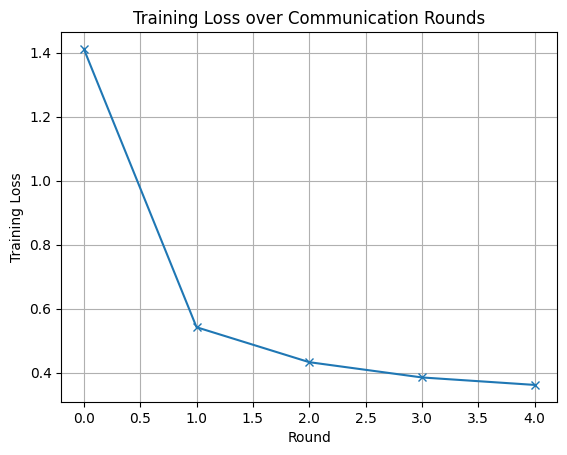

In [13]:
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")
plt.plot(loss, marker='x')
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.title("Training Loss over Communication Rounds")
plt.grid(True)
plt.show()

 ### On obtaining loss curves and convergence rates of the loss function

With loss log

In [14]:
import importlib
import utils
importlib.reload(utils)

from utils import fedavg_loss

In [21]:
# Train

model, loss_curve = fedavg_loss(datalist, T=20, K=5, gamma=0.1, print_every = 10, weights=None)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)
print(abs_dec)
# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")




  Avg training loss at round 10: 1.1035
  Avg training loss at round 20: 0.5965
[0.08619527022043894, 0.10317759911219282, 0.12248683373133362, 0.1382573127746578, 0.1466532905896505, 0.14667211771011335, 0.13904475371042868, 0.12620173692703274, 0.11084696451822929, 0.09516505201657588, 0.08067276676495894, 0.06804903944333418, 0.05740727186202976, 0.04859743714332565, 0.04136320352554346, 0.03543337186177553, 0.0305652101834617, 0.026549642284710906, 0.02322008113066376]
Test Accuracy with 30 ): 85.70%


In [24]:

model, loss_curve = fedavg_disk(datalist,alphas_list,client_sizes, T=20, K=5, gamma=0.1, print_every = 10)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)
print(abs_dec)
# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

  Avg training loss at round 10: 0.4740
  Avg training loss at round 20: 0.3762
[0.4122951630017382, 0.4616392833193006, 0.3041434094560743, 0.1614081802475955, 0.0876049462140086, 0.058362153245504866, 0.039179362287224295, 0.030755473457648286, 0.022063093683090562, 0.019292076419463955, 0.014106107322321482, 0.013411974971876572, 0.009761329961765763, 0.009965862947200865, 0.007168520959632496, 0.007774758839821316, 0.005540980906309334, 0.006269519998212181, 0.004503394460389165]
Test Accuracy with 30 ): 91.18%


### Just some plots of loss curve : No relation with convergence rates, just the shape of the loss

In [31]:
model, loss_curve = fedavg_loss(datalist, T=200, K=5, gamma=0.1, print_every = 10, weights=None)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)

# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

  Avg training loss at round 10: 1.0586
  Avg training loss at round 20: 0.5809
  Avg training loss at round 30: 0.4566
  Avg training loss at round 40: 0.4029
  Avg training loss at round 50: 0.3726
  Avg training loss at round 60: 0.3526
  Avg training loss at round 70: 0.3381
  Avg training loss at round 80: 0.3267
  Avg training loss at round 90: 0.3174
  Avg training loss at round 100: 0.3094
  Avg training loss at round 110: 0.3025
  Avg training loss at round 120: 0.2962
  Avg training loss at round 130: 0.2904
  Avg training loss at round 140: 0.2850
  Avg training loss at round 150: 0.2799
  Avg training loss at round 160: 0.2750
  Avg training loss at round 170: 0.2703
  Avg training loss at round 180: 0.2658
  Avg training loss at round 190: 0.2615
  Avg training loss at round 200: 0.2573
Test Accuracy with 30 ): 93.48%


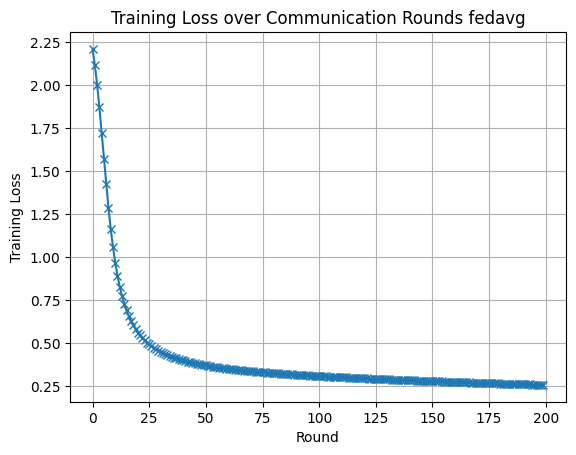

In [32]:
import matplotlib.pyplot as plt

plt.plot(loss_curve, marker='x')
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.title("Training Loss over Communication Rounds fedavg")
plt.grid(True)
plt.show()


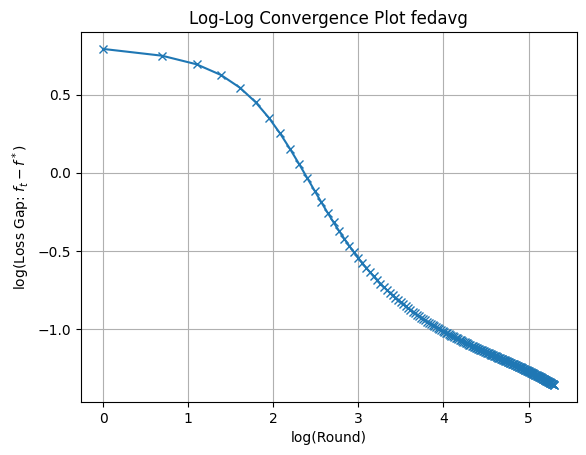

In [33]:
import numpy as np

rounds = np.arange(1, len(loss_curve) + 1)
plt.plot(np.log(rounds), np.log(loss_curve), marker='x')
plt.xlabel("log(Round)")
plt.ylabel("log(Loss Gap: $f_t - f^*$)")
plt.title("Log-Log Convergence Plot fedavg")
plt.grid(True)
plt.show()


In [34]:
model, loss_curve =  fedavg_disk(datalist,alphas_list,client_sizes, T=200, K=5, gamma=0.1, print_every = 10)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)

# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

  Avg training loss at round 10: 0.4679
  Avg training loss at round 20: 0.3715
  Avg training loss at round 30: 0.3382
  Avg training loss at round 40: 0.3163
  Avg training loss at round 50: 0.2977
  Avg training loss at round 60: 0.2809
  Avg training loss at round 70: 0.2659
  Avg training loss at round 80: 0.2528
  Avg training loss at round 90: 0.2412
  Avg training loss at round 100: 0.2308
  Avg training loss at round 110: 0.2215
  Avg training loss at round 120: 0.2131
  Avg training loss at round 130: 0.2053
  Avg training loss at round 140: 0.1982
  Avg training loss at round 150: 0.1916
  Avg training loss at round 160: 0.1856
  Avg training loss at round 170: 0.1800
  Avg training loss at round 180: 0.1748
  Avg training loss at round 190: 0.1700
  Avg training loss at round 200: 0.1656
Test Accuracy with 30 ): 96.41%


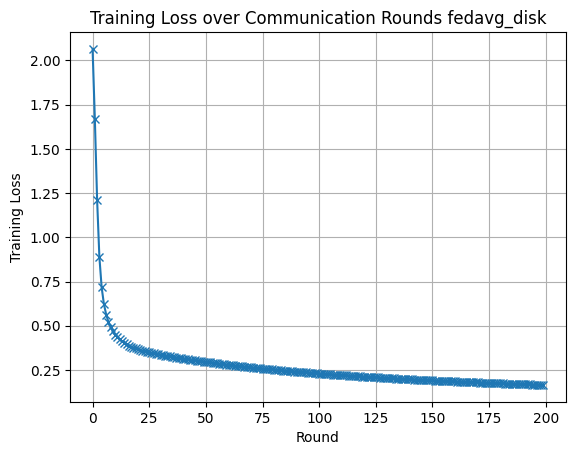

In [35]:
plt.plot(loss_curve, marker='x')
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.title("Training Loss over Communication Rounds fedavg_disk")
plt.grid(True)
plt.show()

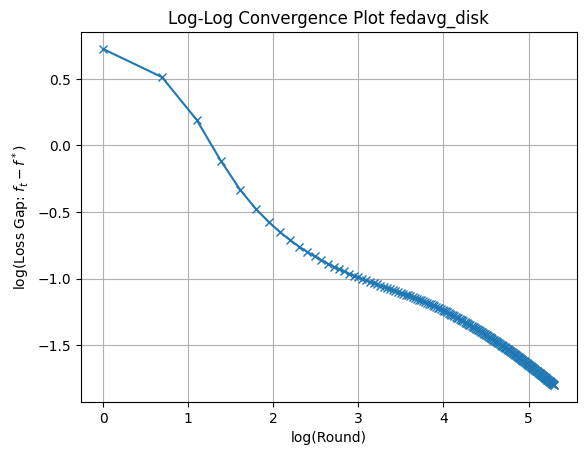

In [36]:
rounds = np.arange(1, len(loss_curve) + 1)
plt.plot(np.log(rounds), np.log(loss_curve), marker='x')
plt.xlabel("log(Round)")
plt.ylabel("log(Loss Gap: $f_t - f^*$)")
plt.title("Log-Log Convergence Plot fedavg_disk")
plt.grid(True)
plt.show()


Parameter K

### Run experiments varying number of local steps K

In [19]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [20]:



run_experiments(
    datalist=datalist,
    param_name='K',
    param_values=[1, 5, 10,20,30,40],
    fixed_params={'T': 20, 'gamma': 0.01},
    loglog=True)


TypeError: run_experiment() got an unexpected keyword argument 'param_name'

In [ ]:
run_experiments(
    datalist=datalist,
    param_name='K',
    param_values=[1,3,5,7,10,12,15],
    fixed_params={'T': 20, 'gamma': 0.01},
    loglog=False)


### I don't know if super useful


### Trying some other plots

### Varying T



In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [ ]:
import matplotlib.pyplot as plt

K      = 10             #number of local GD steps per round
gamma  = 0.1           #learning rate for each GD step
T_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70]  #the different global rounds numbers

#averaging to reduce variance
average_last_n = 5

final_losses = sample_final_losses_vs_T(datalist, T_list, K, gamma, average_last_n)




In [ ]:
# 1) Build arrays
T_arr   = np.array(sorted(final_losses.keys()))
L_arr   = np.array([ final_losses[T] for T in T_arr ])

# 2) Choose a reference f_star (e.g. centralized baseline or min(L_arr))
f_star  = 0

# 3) Compute error e_T = L_arr - f_star
errors  = np.clip(L_arr - f_star, 1e-12, None)

# 4) Fit log(e_T) vs. log(T) to extract slope “-alpha”:
logT    = np.log(T_arr)
logErr  = np.log(errors)
A       = np.vstack([logT, np.ones_like(logT)]).T
alpha_neg, intercept = np.linalg.lstsq(A, logErr, rcond=None)[0]
alpha   = -alpha_neg
C_est   = np.exp(intercept)

print(f"Estimated convergence exponent α ≈ {alpha:.4f},  C ≈ {C_est:.3e}")

# 5) (Optional) Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(logT, logErr, 'o', label="data (log−log)")
xfit = np.linspace(logT.min(), logT.max(), 100)
yfit = alpha_neg * xfit + intercept
plt.plot(xfit, yfit, 'r-', label=f"slope = {alpha_neg:.3f}")
plt.xlabel("log(T)")
plt.ylabel("log(L_T - f*)")
plt.title("Log–Log Fit for Convergence vs. T (fixed K)")
plt.legend()
plt.grid(True)
plt.show()


### Varying K

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [ ]:
import matplotlib.pyplot as plt

T     = 10             #number of local GD steps per round
gamma  = 0.1           #learning rate for each GD step
K_list = [5,10,15,30,45,60]  #the different global rounds numbers

#averaging to reduce variance
average_last_n = 5

final_losses = sample_final_losses_vs_K(datalist, T, K_list, gamma, average_last_n)

In [ ]:
print(final_losses)

In [ ]:
K_arr = np.array(sorted(final_losses.keys()))
# Build the corresponding losses (in the same order)
L_arr = np.array([final_losses[K] for K in K_arr])

print("K_arr:", K_arr)
print("L_arr:", L_arr)

# ── 4) Choose a reference f_star ──
# If you have a centralized baseline loss, use it. Otherwise, use min(L_arr).
f_star = 0
print(f"Using f* = {f_star:.4f}")

# Compute the “error” e_K = L_K - f_star
errors = np.clip(L_arr - f_star, 1e-12, None)  # never let it go to zero


# For a power‐law fit e_K ≈ C / (T·K)^α, we do a regression on (log(TK), log(errors))
logK  = np.log(K_arr)
logL  = np.log(L_arr)             # or np.log(errors) if using f*

A = np.vstack([logK, np.ones_like(logK)]).T
m, b = np.linalg.lstsq(A, logL, rcond=None)[0]
alpha_est = -m       # exponent, since L ≈ C·K^{-α} → logL ≈ −α·logK + log C
C_est     = np.exp(b)

y_pred = m*logK + b
ss_res = np.sum((logL - y_pred)**2)
ss_tot = np.sum((logL - np.mean(logL))**2)
r2     = 1 - (ss_res/ss_tot)
print(f"Fit: L(K) ≈ {C_est:.3e} * K^(-{alpha_est:.3f}),  R² = {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
# (a) raw L vs K
plt.subplot(1,2,1)
plt.plot(K_arr, L_arr, 'o-')
plt.xlabel("K")
plt.ylabel("Final Loss L(K)")
plt.title("Final Loss vs K")
plt.grid(True)

# (b) log–log plot and fitted line
plt.subplot(1,2,2)
plt.plot(logK, logL, 'o', label="data (log)")
xfit = np.linspace(logK.min(), logK.max(), 100)
yfit = m*xfit + b
plt.plot(xfit, yfit, 'r-', label=f"slope={m:.3f}")
plt.xlabel("log(K)")
plt.ylabel("log(L(K))")
plt.title("Log–Log Fit")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Trying moon with features_shift

### But should not improve much the performance. It is better suited for Label Shift


In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [ ]:
n_clients = 30
datalist = make_femnist_datasets(X,y,train,n_clients)
# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print(f" MOON : case with {n_clients} clients, with feature distribution shift")

In [ ]:
model, loss_curve = fedavg_moon(datalist, T=T, K=K, gamma=gamma, mu=0.5)

In [ ]:
test_accuracy = evaluate(model, test_images, test_labels)
print(test_accuracy)

##### It indeed doesn't make a difference from FedAvg